In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #data visualization library
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix  # evaluation metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from statistics import mean
from sklearn.metrics import f1_score, recall_score



In [3]:
# Import data
df = pd.read_csv('dementia_dataset.csv')

# Remove columns not used in model
df.drop(columns = ['Subject ID', 'MRI ID', 'Hand', 'MR Delay'],inplace=True)


# Cleaning and modifying data
df_one = pd.get_dummies(df["Group"])
df_two = pd.concat((df_one, df), axis=1).drop(["Group", "Nondemented", "Converted"], axis=1)
df_three = pd.get_dummies(df_two["M/F"])
df_four = pd.concat((df_three, df_two), axis=1)
df_four = df_four.drop(['F', 'M/F'], axis=1)
data = df_four.rename(columns={"M": "Gender"})
data = data[['Gender', 'Visit', 'Age', 'EDUC', 'SES',
       'MMSE', 'eTIV', 'nWBV', 'ASF', 'Demented']]

# Replacing a few missing values with dataset mean
data['SES'] = data['SES'].fillna(np.mean(data['SES']))
data['MMSE'] = data['MMSE'].fillna(np.mean(data['MMSE']))

# Display first 5 data points
data.head()

,Gender,Visit,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,Demented
0,1,1,87,14,2.000000,27.0,1987,0.696,0.883,0
1,1,2,88,14,2.000000,30.0,2004,0.681,0.876,0
2,1,1,75,12,2.460452,23.0,1678,0.736,1.046,1
3,1,2,76,12,2.460452,28.0,1738,0.713,1.010,1
4,1,3,80,12,2.460452,22.0,1698,0.701,1.034,1


In [4]:
# Initialize LogisticRegression for model and StandardScaler for scaling data
lr = LogisticRegression()
scaler = StandardScaler()

# Features
X = data.iloc[:,:9].to_numpy()

# Label
y = data.iloc[:,-1].to_numpy().reshape(-1)

Training accuracy: 0.8697318007662835
Validation accuracy: 0.8303571428571429
Coefficients: [[ 0.88612725 -0.58995609 -0.72426902 -0.7384435   0.00753986 -2.90902111
  -0.10278669 -0.85312345  0.33161969]]


[Text(0, 0.5, 'non-demented'), Text(0, 1.5, 'demented')]

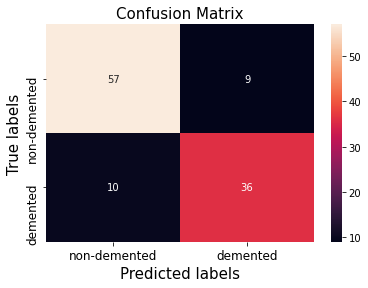

In [54]:
# Training the model with a single split

# Scale data with StandardScaler and fit logistic regression
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
lr.fit(scaler.fit_transform(X_train), y_train)
y_pred_train = lr.predict(scaler.fit_transform(X_train))
y_pred_val = lr.predict(scaler.fit_transform(X_val))
training_acc = accuracy_score(y_train, y_pred_train)
val_acc = accuracy_score(y_val, y_pred_val)
print(f"Training accuracy: {training_acc}")
print(f"Validation accuracy: {val_acc}")
print(f"Coefficients: {lr.coef_}")

conf_mat = confusion_matrix(y_val, y_pred_val) 
ax = plt.subplot()

sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
ax.set_title('Confusion Matrix',fontsize=15)
ax.xaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)
ax.yaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)

Training accuracy avg: 0.8469766161419874
Validation accuracy avg: 0.8322448979591837
Precision avg: 0.8458741830065359
F1 scores avg: 0.7609921609921609
Recall avg: 0.6983447001989201


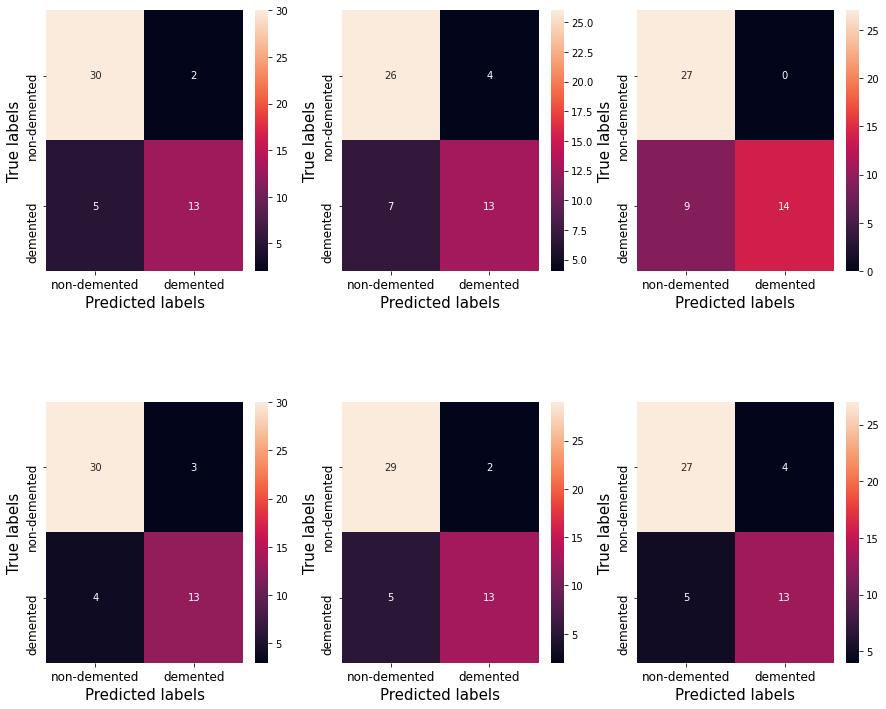

In [102]:
# Training the model with kfold cross validation with k=6

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cv = KFold(n_splits=6, shuffle=True, random_state=42)

training_accuracy = [] # store the training errors
validation_accuracy = [] # store the validation errors
precision_scores = []
recall_scores = []
f1scores = []

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

# Iterate through the indices of train and validation (iteration through each split)
for i, (train_index, val_index) in enumerate(cv.split(y_cv)):
    
    ax = plt.subplot(2,3,i+1)

    X_train_cv, X_val_cv = X_cv[train_index], X_cv[val_index]
    y_train_cv, y_val_cv = y_cv[train_index], y_cv[val_index]
    
    lr.fit(scaler.fit_transform(X_train_cv), y_train_cv)
    y_pred_train_cv = lr.predict(scaler.fit_transform(X_train_cv))
    y_pred_val_cv = lr.predict(scaler.fit_transform(X_val_cv))
    acc_train_cv = accuracy_score(y_train_cv, y_pred_train_cv)
    acc_val_cv = accuracy_score(y_val_cv, y_pred_val_cv)
    
    
    conf_mat = confusion_matrix(y_val_cv, y_pred_val_cv)
    
    precision = conf_mat[1,1]/(conf_mat[0, 1]+conf_mat[1, 1])
    precision_scores.append(precision)
    recall_scores.append(recall_score(y_val_cv, y_pred_val_cv))


    sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels',fontsize=15)
    ax.set_ylabel('True labels',fontsize=15)
    ax.xaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)
    ax.yaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)    
              
    training_accuracy.append(acc_train_cv)
    validation_accuracy.append(acc_val_cv)
    f1scores.append(f1_score(y_val_cv, y_pred_val_cv))
    
#plt.tight_layout()
print('Training accuracy avg:', mean(training_accuracy))
print('Validation accuracy avg:', mean(validation_accuracy))
print('Precision avg:', mean(precision_scores))
print('F1 scores avg:', mean(f1scores))
print('Recall avg:', mean(recall_scores))

Test accuracy: 0.88 Test precision: 0.8709677419354839 Test recall: 0.8709677419354839 Test F1-score: 0.8571428571428571


[Text(0, 0.5, 'non-demented'), Text(0, 1.5, 'demented')]

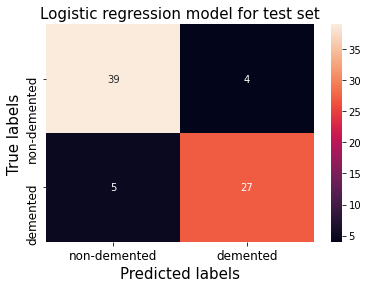

In [103]:
y_pred_test=lr.predict(scaler.fit_transform(X_test))

conf_mat = confusion_matrix(y_test, y_pred_test)

test_accuracy = accuracy_score(y_pred_test, y_test)

test_precision = conf_mat[1,1]/(conf_mat[0, 1]+conf_mat[1, 1])

test_recall = recall_score(y_pred_test, y_test)


print('Test accuracy:',test_accuracy, 'Test precision:', test_precision,'Test recall:', test_recall, 'Test F1-score:', f1_score(y_pred_test, y_test))

ax = plt.subplot()

sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
ax.set_title('Logistic regression model for test set',fontsize=15)
ax.xaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)
ax.yaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)

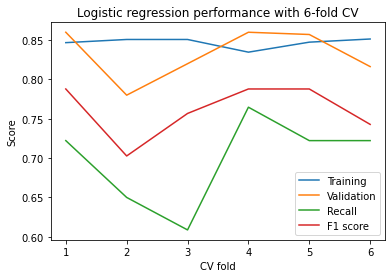

In [109]:
t = [i+1 for i in range(6)]
plt.plot(t, training_accuracy, t, validation_accuracy, t, recall_scores, t, f1scores)
plt.legend(['Training', 'Validation', 'Recall', 'F1 score'], loc='lower right')
plt.title('Logistic regression performance with 6-fold CV')
plt.xlabel('CV fold')
plt.ylabel('Score')
plt.show()

Avg training acc: 0.8543636913244376
Validation accuracies avg: 0.8187755102040817
Precision avg: 0.8424549306902248
F1 score avg: 0.7297821009281455
Recall avg: 0.647314578005115


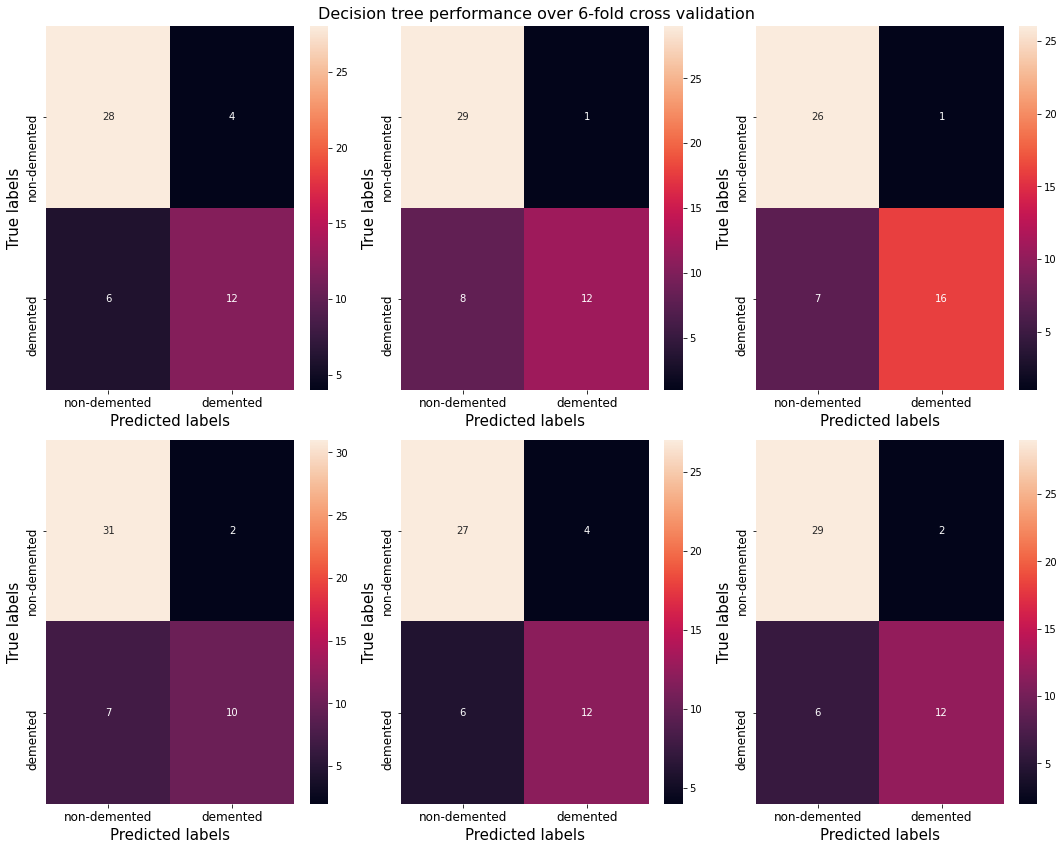

In [104]:
dt = tree.DecisionTreeClassifier(max_depth=2)
cv = KFold(n_splits=6, shuffle=True, random_state=42)

avg_accuracies = []

training_accuracy_dt = [] # store the training errors
validation_accuracy_dt = [] # store the validation errors
precision_scores_dt = []
recall_scores_dt = []
f1scores_dt = []
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.7)


    
# Iterate through the indices of train and validation (iteration through each split)
for i, (train_index, val_index) in enumerate(cv.split(y_cv)):
    
    ax = plt.subplot(2,3,i+1)

    X_train_dt, X_val_dt = X_cv[train_index], X_cv[val_index]
    y_train_dt, y_val_dt = y_cv[train_index], y_cv[val_index]

    dt.fit(scaler.fit_transform(X_train_dt), y_train_dt)

    y_pred_train_dt = dt.predict(scaler.fit_transform(X_train_dt))
    y_pred_val_dt = dt.predict(scaler.fit_transform(X_val_dt))

    acc_train_dt = accuracy_score(y_train_dt, y_pred_train_dt)
    acc_val_dt = accuracy_score(y_val_dt, y_pred_val_dt)


    conf_mat = confusion_matrix(y_val_dt, y_pred_val_dt) 

    precision = conf_mat[1,1]/(conf_mat[0, 1]+conf_mat[1, 1])
    precision_scores_dt.append(precision)
    recall_scores_dt.append(recall_score(y_val_dt, y_pred_val_dt))


    sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels',fontsize=15)
    ax.set_ylabel('True labels',fontsize=15)
    ax.xaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)
    ax.yaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)    

    training_accuracy_dt.append(acc_train_dt)
    validation_accuracy_dt.append(acc_val_dt)
    f1scores_dt.append(f1_score(y_val_dt, y_pred_val_dt))
    

    

plt.suptitle('Decision tree performance over 6-fold cross validation', fontsize=16)
plt.tight_layout()
print('Avg training acc:', mean(training_accuracy_dt))
print('Validation accuracies avg:', mean(validation_accuracy_dt))
print('Precision avg:', mean(precision_scores_dt))
print('F1 score avg:', mean(f1scores_dt))
print('Recall avg:', mean(recall_scores_dt))




Test accuracy: 0.84 Test precision: 0.8571428571428571 Test recall: 0.75 Test F1-score: 0.7999999999999999


[Text(0, 0.5, 'non-demented'), Text(0, 1.5, 'demented')]

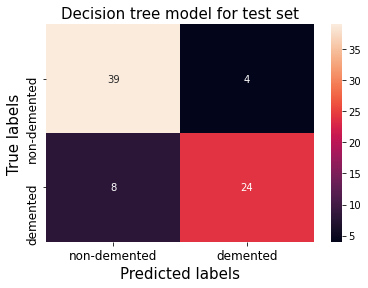

In [105]:
y_pred_test_dt=dt.predict(scaler.fit_transform(X_test))
test_accuracy_dt = accuracy_score(y_pred_test_dt, y_test)
conf_mat = confusion_matrix(y_test, y_pred_test_dt)

test_precision_dt = conf_mat[1,1]/(conf_mat[0, 1]+conf_mat[1, 1])
test_recall_dt = recall_score(y_test, y_pred_test_dt)


print('Test accuracy:',test_accuracy_dt, 'Test precision:', test_precision_dt,'Test recall:', test_recall_dt, 'Test F1-score:', f1_score(y_pred_test_dt, y_test))

ax = plt.subplot()

sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
ax.set_title('Decision tree model for test set',fontsize=15)
ax.xaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)
ax.yaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)


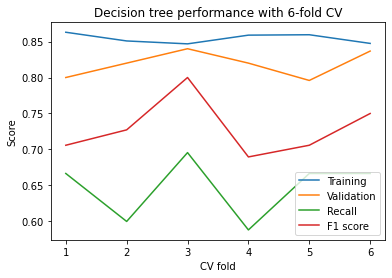

In [108]:
t = [i+1 for i in range(6)]
plt.plot(t, training_accuracy_dt, t, validation_accuracy_dt, t, recall_scores_dt, t, f1scores_dt)
plt.legend(['Training', 'Validation', 'Recall', 'F1 score'], loc='lower right')
plt.title('Decision tree performance with 6-fold CV')
plt.xlabel('CV fold')
plt.ylabel('Score')
plt.show()